# Proximal Langevin Markov chain Monte Carlo algorithms

# Introduction

Modern imaging methods rely strongl on Bayesian inference techniques to solve challenging imaging problems. While Monte Carlo algorithms have turned into standard tools over the past decade, they still face difficulties in handling inference for high-dimensional models. One of the main problems encountered when using MCMC in this settings is that it is difficult to design a Markov chain that efficiently samples the state space of interest.

This paper presents a new and highly efficient Markov chain Monte Carlo methodology to perform Bayesian computation for high dimensional models that are log-concave and non-smooth, a class of models that is central in image processing. The methodology improves the Metropolis-adjusted Langevin algorithm MALA using convex optimisation algorithms and proximal operators enabling us to capture local properties of the target density and explore the parameter space efficiently.


# Context

Most of the sampling techniques known so far do not scale to high-dimension and become impractible when the number of data samples is huge.
## log-concave distributions

In this report, we study sampling algorithms for sampling from a log-concave distribution.
We first introduce log-concave distributions, a class of probability distributions widely used in modern high dimensional statistics.
>#### Definition 
It is the class of all densities $\pi$ on $\mathbb{R}$ or on $\mathbb{R}^n$ that can be written as
$$\pi(x) = \frac{\exp^{g(x)}}{k}$$
Where $g$ is concave, and $k$ is the normalizing constant.

#### Assumptions:
$g: \mathbb{R}^n \to [0, +\infty)$  is a concave, upper semicontinuous function satisfying $\lim\limits_{\Vert x\Vert \rightarrow \infty} g(x) = - \infty$.
>#### Definition (Class of distribution $\mathcal{E}(\beta,\gamma)$)
We say that $\pi$ belongs to the one-dimensional class of distributions with
exponential tails $\mathcal{E}(\beta,\gamma)$ if for some $u$, and some constants
$\gamma> 0$ and $\beta > 0$, $\pi$ takes the form
$$\pi(x) \propto \exp(-\gamma |x|^{\beta}), ~~~~ |x|> u$$


## Geometric ergodicity
###  Geometric convergence of Metropolis chains

In this report, we will be brought to study geometric convergence properties of P-MALA. Indeed, some of the stability properties enjoyed by geometrically ergodic chains in simulation motivate our evaluations. We note, that such chains have central limit theorems and the like available, which makes it much easier to assess the algorithms.
Moreover, without geometric ergodicity algorithms will give rise to sample paths having 'heavy-tailed excursions' away from the centre of the distribution, leading to instability of estimating procedures.

>#### Definition (Total variation norm)
Let (X, $\mathcal{X}$) be a measurable space and let $\mu$, $\nu$  be two probability measures. The total variation norm between $\mu$ and $\nu$ noted $\Vert \mu-\nu\Vert_{TV}$, is defined by $$\Vert \mu-\nu\Vert_{TV} = 2 sup \{|\mu(f)-\nu(f)|:~f \text{ is measurable}, 0\leq f \leq 1\}$$

>#### Definition (Minorizing condition)
Let $P$ be a markov kernel on  $X\times\mathcal{X}$, and let $V:X\to[1,\infty[ $ a measurable function. For all $d>0$, there exists $\epsilon_d>0$ and a probability measure $\mu_d$ such that
$$ \forall x \in C_d :=\{V\leq d\}, ~~~~~~ P(x,.) \geq \epsilon_d \mu_d(.)$$ 





>#### Definition (Drift condition)
Let $V:X\to[1,\infty[ $ a measurable function. There exists a constant $(\lambda,b)\in(0,1)\times\mathbb{R}^+ $ such that $$ \forall x \in X, ~~~~~PV(x) \leq \lambda V(x) +b $$


>#### Definition (Geometric ergodicity)
Let $P$ be an irreductible aperiodic markov kernel on  $X\times\mathcal{X}$. Assume that both the minorizing and drift condition are satisfied for some measurable function
$V \geq 1$. Then there exists a constant $\rho \in (0,1)$ such that $\forall n \in \mathbb{N}$ and $\forall x,x'\in X$
$$ \Vert P^n(x,.) - P^n(x',.)\Vert_{TV} \leq \rho^n (V(x)+V(x'))$$

There are two conditions on the target density $\pi$, which essentially suffice to ensure geometric ergodicity:
+ First, the tails of $\pi$ need to be uniformly exponential or lighter. In one dimension this was essentially shown to be a necessary and sufficient condition.

+ In higher dimensions we need a second condition, requiring that $\pi$ behave sufficientlysmoothly in the tails. This is stated more precisely, as a curvature condition on the contours of the target density. 

## Langevin Markov chain Monte Carlo
#### Proposed method
Let $\pi$  denote a log-concave probability density function on $\mathbb{R}^n$, one from which it is desired to draw an ensemble of independent and identically distributed samples. To do so, we will first consider Langevin Markov chain Monte Carlo method.

The Metropolis-adjusted Langevin algorithm is a Markov chain Monte Carlo method for obtaining random samples from a probability distribution for which direct sampling is difficult. MALA uses a combination of two mechanisms to generate the states of a random walk that has the target probability distribution as an invariant measure:
+ Candidates are proposed using Langevin diffusion, which use information about the target density in the
form of the gradient of $\log\pi$.
+ The candidates are accepted or rejected using Metropolis–Hastings algorithm.

### Unadjusted Langevin Algorithm
Let $\pi$ be a probability distribution that is everywhere non-zero and differentiable so that $\nabla \mathrm{log} \pi $ is well-defined.

>#### Definition
Let $\pi$ be a probability distribution on $\mathbb{R}^n$. A process $Y(t)$ is a Langevin diffusion process on $\mathbb{R}^n$ that has $\pi$ as stationary distribution is the solution to the equation$$ dY(t) = \frac{1}{2} \mathrm{log}\pi(Y(t))dt + dW(t), \space Y(0) = y_0 $$where $W$ is the $n$-dimensional Brownian motion (see appendix for definition).

Under additional assumptions, this equation has a unique strong solution and converges in distribution to $\pi$ which makes it interesting for simulating from $\pi$.


In general, the above stochastic differential equation cannot be solved exactly and the below first-order Euler discretisation is used instead:

>#### Definition (Discrete-time approximation of the Langevin diffusion process)
The discrete-time approximation of the Langevin diffusion process with step size $\delta$ with a forward Euler approximation is the following process, also called ULA$$ L^{(m+1)} = L^{(m)} + \frac{\delta}{2} \nabla \mathrm{log} \pi (L^{(m)}) + \sqrt{\delta} Z^{(m)}$$where$$ Z^{(m)} \sim \mathcal{N} (0, \mathbb{I}_n) $$The parameter $\delta$ controls the incrementation and the variance of the Gaussian pertutbation.

These approaches are interseting typically because of their convergence under certain stability conditions. ULA also presents a good approximation of $Y(t)$ and converges to en ergodic measure that is close to $\pi$.



### Metropolis Adjusted Langevin Algorithme
While ULA approximates $\pi$, the Metropolis Adjusted Langevin corrects the approximation error by introducing a rejection step that guarantees convergence to the correct target density $\pi$. In order to describe the approach, it is useful to outline the standard construction of the Hastings and Metropolis algorithms. To correct for first-order integration error that is introduced from the discretisation, we consider the above update rule as defining a proposal candidate :
 $$ \tilde{L}^{(m+1)} = L^{(m)} + \frac{\delta}{2} \nabla \mathrm{log} \pi (L^{(m)}) + \sqrt{\delta} Z^{(m)}$$
 

A Metropolis-Hastings acceptance probability is then calculated after a step. The algorithm accepts the candidate as the new state of the Markov chain with probability
$$ \alpha(L^m, \tilde{L}^{m+1} )= min(1, \frac{\pi(\tilde{L}^{(m+1)}) q(L^m| \tilde{L}^{(m+1)})}{  \pi(L^{m} )q(\tilde{L}^{(m+1)}|L^m)})$$
where
$q(x) \sim \mathcal{N}(  x + \frac{\delta}{2} \nabla \mathrm{log} \pi (x),~ \delta\mathbb{I}_n )$ is the proposal distribution, such that the transition probability density from $x$ to $x'$ is  $$q(x'|x) \propto \exp\left(- \frac{1}{2\delta} \Vert x' - x - \frac{\delta}{2} \nabla log \pi(x) \Vert^2 \right) $$ 
Otherwise, with probability equal to $1 −  \alpha(L^m, \tilde{L}^{m+1} )$, the chain stays at the same position.


>#### Algorithm 1: Metropolis adjusted Langevin algorithm (MALA)
>**Inuput:** n, step size
>
>**Output:** $L^1,..., L^n$
>
>**for** $m=1,...,n$  **do**
>
>  >Draw independently  $\tilde{L}^{(m+1)} \sim \mathcal{N}(  L^m + \frac{\delta}{2} \nabla \mathrm{log} \pi (L^m),  ~\delta\mathbb{I}_n )$ and $U^{m+1} \sim Unif(0,1)$
> set $$
L^{m+1} = \left\{
    \begin{array}{ll}
        \tilde{L}^{m+1} & \mbox{if } U^{m+1} \leq \alpha(L^m, \tilde{L}^{m+1} )  \\
        L^m & \mbox{otherwise}
    \end{array}
\right.
$$
**end**

The Metropolis-Hastings step that underlies the MALA algorithm ensures that the resulting Markov chain has the correct stationary distribution. With this choice of $\alpha$ we have that $\pi$ is invariant: that is, satisfies $ \pi(A)=\int \pi(x)Q(x,A)\, \mathrm{d}x,~x\in, A\in$

Provided the chain is suitably irreducible and aperiodic, it
is then standard that the n-step transition probabilities, converge to $\pi$ in the total variation norm.
The purpose of the MetropolisHastings correction (2) is to ensure that the target density π is stationary for the Markov
chain.



In the next section of the notebook can be found an implementation of ULA and MALA.


# Implementation

In [8]:
import seaborn as sns
import autograd.numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
# package which differentiates standard Python and Numpy code
from autograd import grad
# to get progress bars
from tqdm import tqdm
sns.set_style("whitegrid")

### Unadjusted Langevin Algorithm

In [9]:
def ULA(n_samples, initial_state, log_p, step_size):
    d = len(initial_state)
    samples = np.zeros((n_samples,d))
    x = initial_state
    grad_log_p = grad(log_p)

    for i in range(n_samples):
        x += step_size / 2 * grad_log_p(x) + np.sqrt(step_size) * scs.multivariate_normal.rvs(size=d)
        samples[i,:] = x
  
    return samples

### Metropolis Adjusted Langevin Algorithm



In [15]:
def MALA(n_samples, initial_state, log_p, step_size):

    d = len(initial_state)
    samples = np.zeros((n_samples,d))
    accepted = np.zeros(n_samples)
    x = initial_state
    grad_log_p = grad(log_p)

    for i in range(n_samples):
        y = x + step_size / 2 * grad_log_p(x) + np.sqrt(step_size) * scs.norm.rvs(size=d)
        samples[i] = y
        log_q = lambda x, y : scs.norm.logpdf(y, x + step_size / 2 * grad_log_p(x), step_size * np.eye(d))

        if log_p(y) + log_q(y,x) - log_p(x) - log_q(x,y) < 0:
            y = x
            accepted[i] = 1
        else:
            accepted[i] = 0

    return samples, accepted

### Illustration (In 1D)

In [16]:
def log_gauss(mu, sigma):
    return lambda x : - ((x - mu) / sigma)**2 / 2 - np.log(sigma * np.sqrt(2 * np.pi))

log_quartic_dist = lambda x : - x**4

In [22]:
def hist_and_true_dens(samples, log_density):
    x = np.arange(min(samples), max(samples), 0.1)
    plt.figure(figsize=(7.2,4.5))
    sns.histplot(samples, stat='density', legend=False)
    plt.plot(x, np.exp(log_density(x)), color='darkblue', label='True density')
    plt.title('Comparison wrt true density', fontsize =14)
    plt.legend()


def test_convergence_mean(samples_list, param_name, params, target_mean, ylim=True):
    plt.figure(figsize=(8.0,5.0))
    if ylim:
        plt.ylim((target_mean-1, target_mean+1))
    plt.axhline(target_mean, color="black", lw=2, label='Target mean')

    for k in range(len(params)):
        samples = samples_list[k]
        t = np.arange(1, len(samples) + 1)
        samples_sum = np.cumsum(samples) / t
        plt.plot(t, samples_sum,  lw=1.2, label=param_name+'='+str(params[k]))

    plt.legend()


def plot_accept_prob(accept_list, param_name, params):
    y = np.empty_like(params)
  
    for k in range(len(params)):
        accept = accept_list[k]
        y[k] = len(accept[accept == 1]) / len(accept)
  
    plt.figure(figsize=(7.2,4.5))
    plt.semilogy(params, y)
    plt.xlabel(param_name)
    plt.ylabel('Acceptance probability')
    

In [23]:
log_p = log_gauss(mu=2,sigma=5)
n_samples = 3000
x0 = np.array([2])
step_size = 30
MALA_samples, accepted = MALA(n_samples, x0, log_p, step_size)
MALA_samples_accepted = MALA_samples[accepted == 1]

To test our algorithm, we plotted some graphs wheren we compare a chosen target density and the result obtained by MALA. To do so, we overlay their histograms.

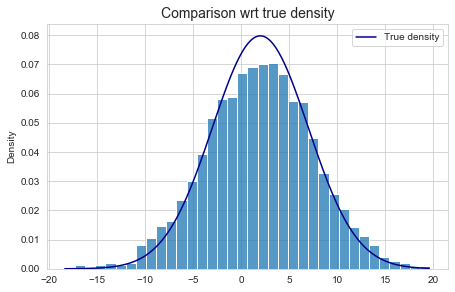

In [24]:
hist_and_true_dens(MALA_samples_accepted, log_p)

Now let's try if our algorithm works as well as in the graph above for different step sizes.

In [26]:
log_p = log_gauss(mu=2,sigma=5)
n_samples = 300
x0 = np.array([5])
step_sizes = np.array([1, 10, 25, 40, 100])
MALA_samples_list = []

for step_size in step_sizes:
    MALA_samples, accepted = MALA(n_samples, x0, log_p, step_size)
    MALA_samples_list.append(MALA_samples[accepted == 1])

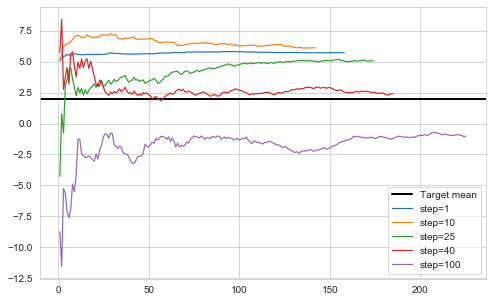

In [27]:
test_convergence_mean(MALA_samples_list,'step' ,step_sizes, 2, ylim=False)

We notice that there exists an optimal step size is $\approx 50$, for which the mean of the Markov chain obtained by MALA converges to the target density mean. When the step sizes are too small or too big these convergence properties diminish.

In [29]:
log_p = log_gauss(mu=2,sigma=5)
n_samples = 3000
x0 = np.array([5])
step_sizes = np.linspace(1,100,10)
MALA_accept_list = []

for step_size in step_sizes:
    _, accepted = MALA(n_samples, x0, log_p, step_size)
    MALA_accept_list.append(accepted)

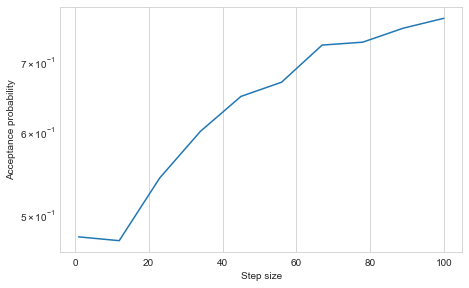

In [30]:
Weplot_accept_prob(MALA_accept_list, 'Step size', step_sizes)

We notice that as the step size gets bigger, the acceptance probability takes higher values. By analogy with the previous comment, the acceptance probability should not take extreme values, typically here what we would consider as the optimal intervall for the acceptance probability would be $[0.5, 0.7]$.
Thus, the choice of an optimal step size can be determined by the acceptance probability.

### Limitations of ULA and the Langevin MCMC
These approaches are unfortunately not very useful:

* The Langevin diffusion process $Y(t)$ is not easy to sample from in general, which makes it not very versatile.
- ULA can get transient in certain cases (especially when $\pi$ belongs to a certain class). Even with the addition of a Metropolis-Hastings rejection step to ensure convergence with MALA, geometric ergodicity is not always guarenteed (see Appendix for geometric ergodicity definition).
+ $\pi$ is required to be $\mathcal{C}^1$ for MALA to work, which limits the scope of the distributions we can approach.

We illustrate an adversarial example of these limitations bellow.

#### MALA Adversarial example

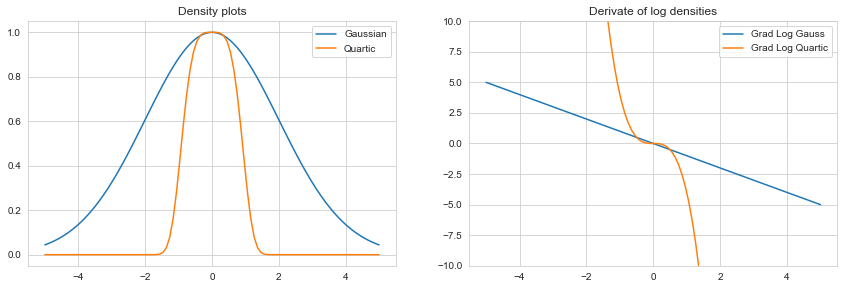

In [33]:
x = np.linspace(-5,5,100)
plt.figure(figsize=(14.5,4.5))

plt.subplot(1,2,1)
plt.plot(x, np.exp(log_gauss(0,2)(x)) * 2 * np.sqrt(2 * np.pi), label='Gaussian')
plt.plot(x, np.exp(log_quartic_dist(x)), label='Quartic')
plt.title('Density plots')
plt.legend()

plt.subplot(1,2,2)
plt.ylim((-10,10))
grad_q = grad(log_quartic_dist)
y = np.array([grad_q(x_j) for x_j in x])
plt.plot(x, -x, label='Grad Log Gauss')
plt.plot(x, y, label='Grad Log Quartic')
plt.title("Derivate of log densities")
plt.legend()

+ **First graphic:** We can see that the tail of the Quartic distribution is lighter than the Gaussian distribution. Which makes it more difficult to sumilate where the quartic density has non null values

+ **Second graphic:** To clear

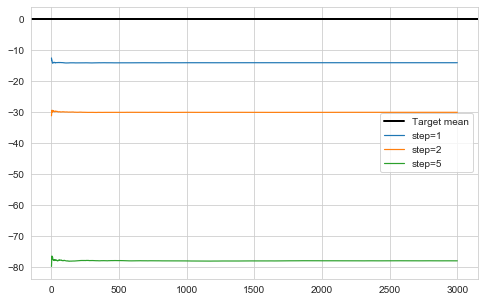

In [39]:
log_p = log_quartic_dist
n_samples = 3000
x0 = np.array([2])
step_sizes = np.array([1, 2, 5])
MALA_samples_list = []

for step_size in step_sizes:
    MALA_samples, accepted = MALA(n_samples, x0, log_p, step_size)
    MALA_samples_list.append(MALA_samples[accepted == 1])

test_convergence(MALA_samples_list,'step' ,step_sizes, 0, ylim=False)

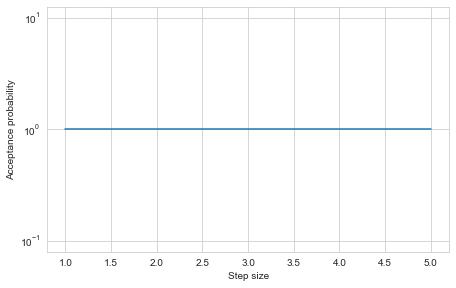

In [35]:
log_p = log_quartic_dist
n_samples = 3000
x0 = np.array([2])
step_sizes = np.linspace(1,5,10)
MALA_accept_list = []

for step_size in step_sizes:
    _, accepted = MALA(n_samples, x0, log_p, step_size)
    MALA_accept_list.append(accepted)

plot_accept_prob(MALA_accept_list, 'Step size', step_sizes)

## A proximal point of view


> #### Definition (Proximity mappings)
The $\lambda$-proximity mapping of a concave function $g$ is defined for any $\lambda>0$ as
$$ prox_g^{\lambda}(x) = \arg\max_{u\in\mathbb{R}^n}~~ g(u) - \frac{1}{2\lambda}\Vert u -x\Vert^2 $$

Similarly to gradient mappings, $prox_g^{\lambda}$ also moves points in the direction of the minimum of $g$.
>#### Definition (Moreau approximations)
For any $\lambda>0$, the $\lambda$-Moreau-Yosida envelope of $g$ is a carefully regularised approximation of $g$ given by
$$\pi_{\lambda}(x) = \sup_{u\in\mathbb{R}^n} \pi(u)\exp\left(-\frac{1}{2\lambda}\Vert u - x \Vert\right)/k'$$
where $k'\in \mathbb{R}^+$ is the normalizing constant.

####  Properties
+ #### Convergence to $\pi$: $$\pi_{\lambda}(x) \to \pi(x)~~~~ \text{as}~~ \lambda \to 0.$$


## When Moreau meets Langevin
The main idea is to replace the non-smooth $\pi$ with a carefully designed smooth approximation $\pi_{\lambda}$ which, by construction can be as close to $\pi$ as we want by adjusting the approximation parameter $\lambda>0$. 
Thus, if $\pi$ is not continuously differentiable, but the proximity operator associated
with $\pi$ is available, we can consider sampling algorithms that use the $\lambda$-Moreau-Yosida envelope $\pi_{\lambda}$ instead of $\pi$.

### Proximal unadjusted Langevin algorithm
We first approximate the Langevin diffusion $Y(t)$ by $Y_{\lambda}(t)$ defined as 

$$ dY_{\lambda}(t) = \frac{1}{2} \mathrm{log}\pi_{\lambda}(Y(t_{\lambda}))dt + dW(t), \space Y(0) = y_0 $$
such that  $Y_{\lambda}$ has an invariant measure $\pi_{\lambda}$

Since it is only possible to analytically solve the stochastic equation above in few specific cases, we consider a discrete-time Eumer-Maruyama approximation:
$$ Y^{(m+1)} = Y^{(m)} + \frac{\delta}{2} \nabla \mathrm{log} \pi_{\lambda} (L^{(m)}) + \sqrt{\delta} Z^{(m)}$$
In an equivalent way using the fact that $\nabla \mathrm{log} \pi_{\lambda}(x) = (prox_g^{\lambda}(x)-x)/\lambda$ we obtain 
$$ Y^{(m+1)} = \left( 1-\frac{\delta}{2\lambda}\right)Y^{(m)} + \frac{\delta}{2\lambda} prox_g^{\lambda}( Y^{(m)}) +  \sqrt{\delta} Z^{(m)}$$
where$$ Z^{(m)} \sim \mathcal{N} (0, \mathbb{I}_n) $$
The parameter $\delta$ controls the incrementation and the variance of the Gaussian pertutbation as mentionned before.

The regularity properties of $\pi_{\lambda}$ will lead to discrete approximations with favourable stability and convergence properties. 
#### Selecting the optimal value for $\lambda$:
+ Since we want to simulate from $\pi$, considering the discrete approximation of a Langevin diffusion with invariant measure $\pi_{\lambda}$,  $\lambda$ should be set as small as possible to ensure that $\pi_{\lambda}$ is close to $\pi$.

+ From a convex optimisation viewpoint $\lambda$ should not be smaller than $\frac{\delta}{2}$

>#### Definition (P-ULA)
We define the optimal $\lambda$ as the smallest value within the set $[\frac{\delta}{2},\infty[$.
>
>By setting $\lambda = \frac{\delta}{2}$ we obtain the P-ULA Markov chain defined as :
$$  Y^{(m+1)} =  prox_g^{\lambda}( Y^{(m)}) +  \sqrt{\delta} Z^{(m)} $$ 
where$$ Z^{(m)} \sim \mathcal{N} (0, \mathbb{I}_n) $$

### Convergence of P-ULA



### Proximal Metropolis-adjusted Langevin algorithm
By analogy to MALA, to correct for first-order integration error that is introduced from the discretisation, we supplement P-ULA with a Metropolis–Hasting accept–reject step guaranteeing convergence to the target density $\pi$. Therefore, we use P-ULA as proposal candidate: